In [1]:
'''
feature selection with Boruta
'''
import os, sys
from datetime import datetime
import argparse
import pandas as pd
import numpy as np
import torch
import optuna
from sklearn.model_selection import KFold
from BorutaShap import BorutaShap
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go
import json
import pickle
# 检测运行环境
def in_notebook():
    return 'IPKernelApp' in getattr(globals().get('get_ipython', lambda: None)(), 'config', {})

if in_notebook():
    from IPython.display import clear_output, display
    notebook_dir = os.getcwd()
    src_path = os.path.abspath(os.path.join(notebook_dir, '..'))
    N_TRIAL = 100 # boruta 特征选择次数
    OUTCOME_IX = 0
    IMPORTANCE_MEASURE = 'gini' # gini, shap, perm
else:
    src_path = os.path.abspath(os.path.dirname(os.path.dirname(__file__)))
    parser = argparse.ArgumentParser(description='')
    parser.add_argument('-n',metavar= 50, type=int, default=50,help='''optuna优化尝试次数''')
    parser.add_argument('-outcome_ix',metavar=0, type=int, default=0,help='''选择预测结局, 为 `get_ite_features()`返回的预设 outcomes 列表的索引''')
    parser.add_argument('-importance',metavar='gini', type=str, default='shap',help='''特征重要性度量方式''')
    sys_args = parser.parse_args()
    N_TRIAL = sys_args.n
    OUTCOME_IX = sys_args.outcome_ix
    IMPORTANCE_MEASURE = sys_args.importance

sys.path.append(src_path) if src_path not in sys.path else None
from src.utils import *
from src.model_utils import *
from src.setup import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'current device: {DEVICE}')

current device: cpu


In [16]:
df = pd.read_csv(f'{DATA}/imputed/MIMIC_IV_clean_imputed.tsv.gz', sep='\t', index_col='ID')
cate_vars, cont_vars, outcomes = get_cleaned_vars('MIMIC_IV')

X = df[[*cate_vars, *cont_vars]].copy()
y = df[outcomes[OUTCOME_IX]].copy()

In [17]:
corr_mat = X.corr()
for col in corr_mat.columns:
    mask_high_corr = (corr_mat[col] > 0.8) & (corr_mat[col].index != col)
    high_corr = (corr_mat[col][mask_high_corr]).to_dict()
    for var, corr_coef in high_corr.items():
        print(f'{col}:{var}: {corr_coef:.2f}')

weight:BMI: 0.88
BMI:weight: 0.88
DBP:MAP: 0.93
MAP:DBP: 0.93
RBC:Hb: 0.90
RBC:HCT: 0.92
Hb:RBC: 0.90
Hb:HCT: 0.97
HCT:RBC: 0.92
HCT:Hb: 0.97
ALT:AST: 0.92
AST:ALT: 0.92


In [18]:
# 聚合特征
X['server_cancer_AIDS'] = X[['metastatic_cancer', 'hematologic_cancer', 'AIDS']].max(axis=1)
X['MV/NIMV'] = X[['MV', 'NIPPV']].max(axis=1) # NIPPV is actually NIMV, correct here.

# 去除高相关性特征、综合评分、被聚合的原始特征
X = X.drop(columns=['height', 'weight', 'DBP', 'RBC', 'HCT', 'ALT',
                    'OASIS', 'Charlson', 'APS_III', 'SAPS_II', 'SIRS',
                    'SOFA', 'SOFA_renal', 'SOFA_cardio', 'SOFA_coagulation', 'SOFA_liver', 'SOFA_respiration', 'SOFA_cns',
                    'metastatic_cancer', 'hematologic_cancer', 'AIDS', 'MV', 'NIPPV',
                   ])

In [19]:
# model = XGBClassifier(n_estimators=200, 
#                       objective='binary:logistic', eval_metric='logloss',
#                       tree_method="hist",
#                       booster='gbtree',
#                       n_jobs=-1,
#                       device = DEVICE)

model = RandomForestClassifier(n_jobs=-1)

In [20]:
feature_selector = BorutaShap(
                              # model=model, 
                              # importance_measure='shap',
                              importance_measure=IMPORTANCE_MEASURE,
                              classification=True,
                              pvalue=0.05)

feature_selector.fit(X, y, 
                     n_trials=N_TRIAL, 
                     random_state=19960816,
                     sample=True,
                     train_or_test='test', 
                     normalize=True,
                     verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

22 attributes confirmed important: ['NE%', 'Fg', 'APTT', 'PH', 'Glu', 'BUN', 'NE#', 'LYM%', 'Scr', 'PLT', 'WBC', 'PaO2', 'Lac', 'STB', 'age', 'BMI', 'PT', 'LYM#', 'temperature', 'PaCO2', 'Na+', 'heart_rate']
15 attributes confirmed unimportant: ['MV/NIMV', 'GCS', 'K+', 'AST', 'Ca2+', 'HCO3-', 'Hb', 'cancer', 'SPO2', 'CCRT', 'sex', 'MAP', 'respir_rate', 'server_cancer_AIDS', 'PaO2/FiO2']
1 tentative attributes remains: ['SBP']


In [12]:
set_exit_sep = set(['K+', 'Scr', 'BUN', 'NE%', 'heart_rate', 'APTT', 'PLT', 'Lac', 'Na+', 'PaO2/FiO2'])
set1 = set(['NE%', 'Fg', 'APTT', 'NIPPV', 'PH', 'Glu', 'BUN', 'NE#', 'LYM%', 'PaO2/FiO2', 'Scr', 'PLT', 'CCRT', 'WBC', 'PaO2', 'Lac', 'STB', 'age', 'BMI', 'PT', 'LYM#', 'temperature', 'PaCO2', 'Na+', 'heart_rate'])
set2 = set(['BMI', 'PaCO2', 'Scr', 'WBC', 'temperature', 'PH', 'PaO2', 'PLT', 'NE#', 'Glu', 'heart_rate', 'PT', 'LYM#', 'APTT', 'NIPPV', 'LYM%', 'BUN', 'Na+', 'Fg', 'PaO2/FiO2', 'NE%', 'STB', 'Lac', 'age'])

In [13]:
set1 & set2 & set_exit_sep

{'APTT', 'BUN', 'Lac', 'NE%', 'Na+', 'PLT', 'PaO2/FiO2', 'Scr', 'heart_rate'}

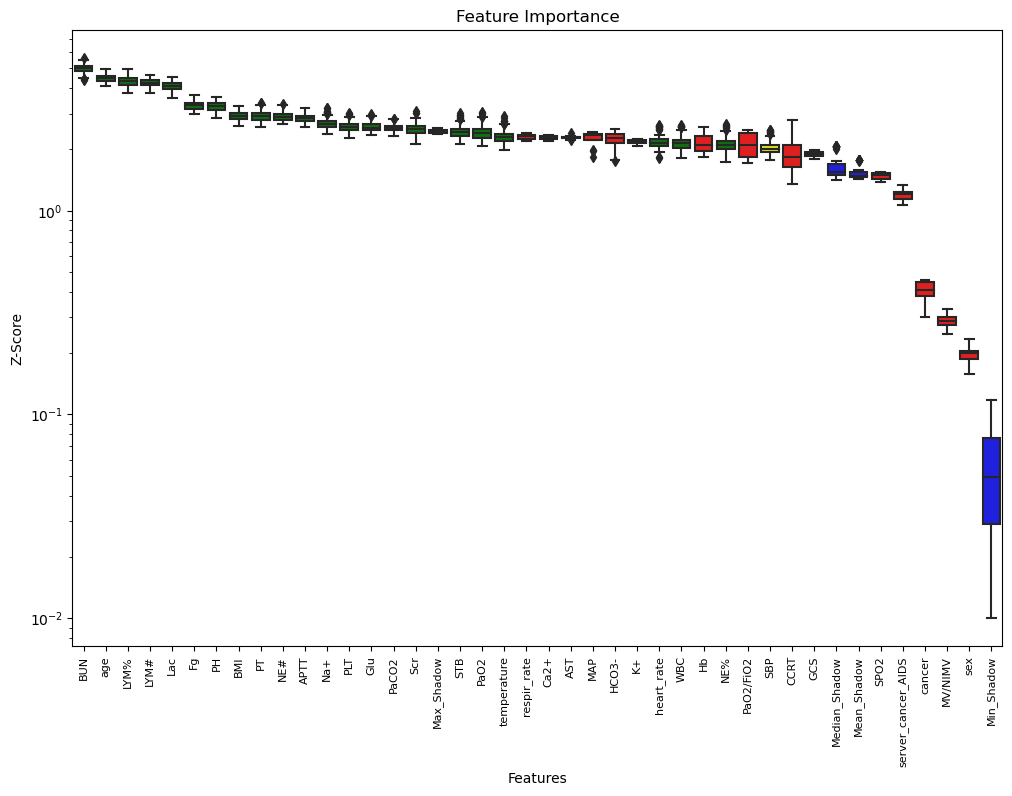

In [21]:
feature_selector.plot()
# 22 attributes confirmed important: ['NE%', 'Fg', 'APTT', 'PH', 'Glu', 'BUN', 'NE#', 'LYM%', 'Scr', 'PLT', 'WBC', 'PaO2', 'Lac', 'STB', 'age', 'BMI', 'PT', 'LYM#', 'temperature', 'PaCO2', 'Na+', 'heart_rate']
# 15 attributes confirmed unimportant: ['MV/NIMV', 'GCS', 'K+', 'AST', 'Ca2+', 'HCO3-', 'Hb', 'cancer', 'SPO2', 'CCRT', 'sex', 'MAP', 'respir_rate', 'server_cancer_AIDS', 'PaO2/FiO2']
# 1 tentative attributes remains: ['SBP']

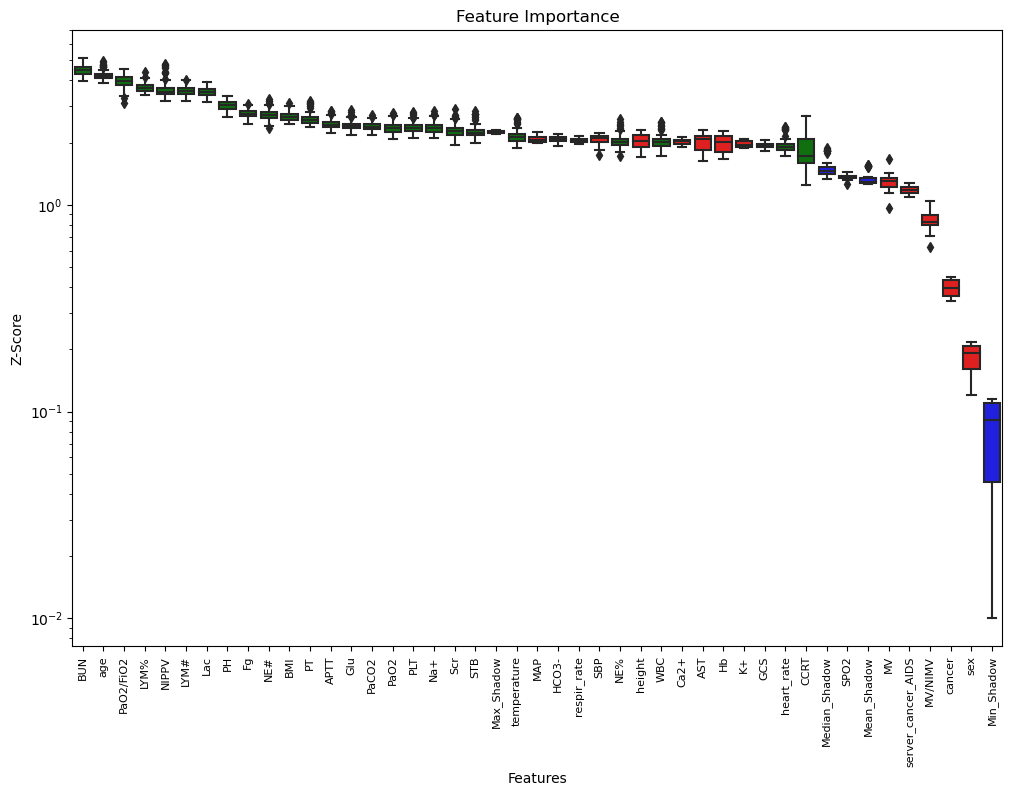

In [8]:
feature_selector.plot()
# 25 attributes confirmed important: ['NE%', 'Fg', 'APTT', 'NIPPV', 'PH', 'Glu', 'BUN', 'NE#', 'LYM%', 'PaO2/FiO2', 'Scr', 'PLT', 'CCRT', 'WBC', 'PaO2', 'Lac', 'STB', 'age', 'BMI', 'PT', 'LYM#', 'temperature', 'PaCO2', 'Na+', 'heart_rate']
# 16 attributes confirmed unimportant: ['MV/NIMV', 'GCS', 'K+', 'MV', 'Ca2+', 'HCO3-', 'SBP', 'AST', 'Hb', 'cancer', 'SPO2', 'sex', 'height', 'MAP', 'respir_rate', 'server_cancer_AIDS']
# 0 tentative attributes remains: []

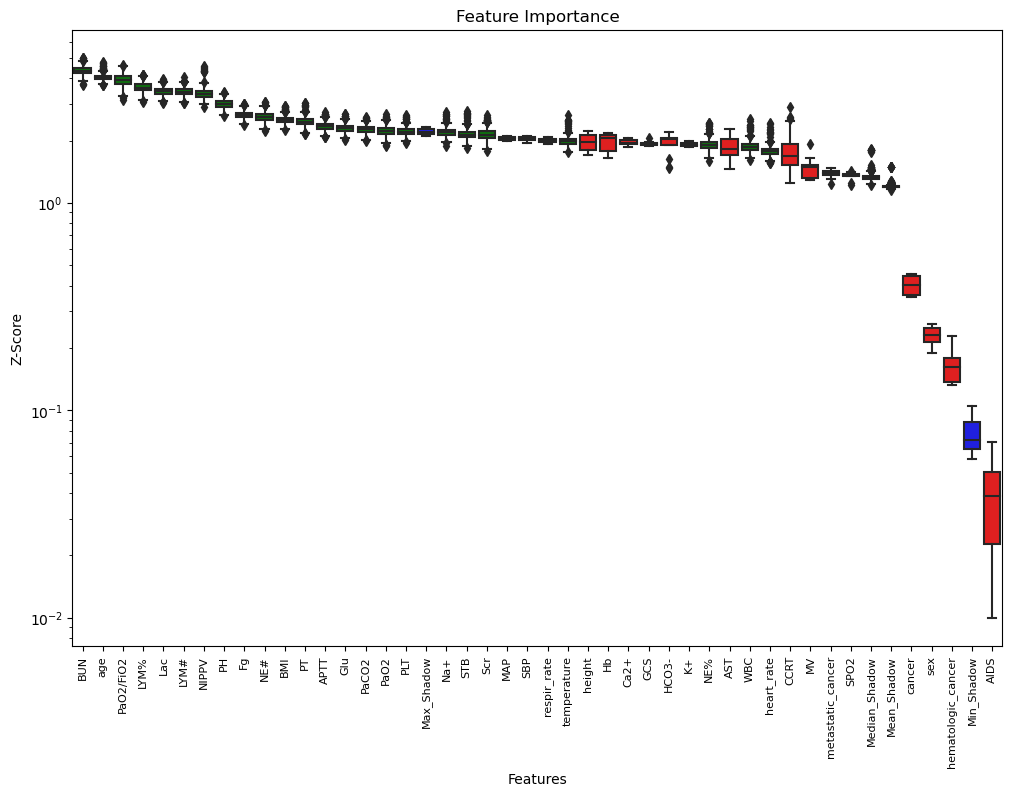

In [26]:
# feature_selector.plot()
# 24 attributes confirmed important: ['BMI', 'PaCO2', 'Scr', 'WBC', 'temperature', 'PH', 'PaO2', 'PLT', 'NE#', 'Glu', 'heart_rate', 'PT', 'LYM#', 'APTT', 'NIPPV', 'LYM%', 'BUN', 'Na+', 'Fg', 'PaO2/FiO2', 'NE%', 'STB', 'Lac', 'age']
# 18 attributes confirmed unimportant: ['metastatic_cancer', 'CCRT', 'GCS', 'Hb', 'cancer', 'MV', 'SBP', 'height', 'AIDS', 'AST', 'SPO2', 'hematologic_cancer', 'MAP', 'sex', 'K+', 'respir_rate', 'Ca2+', 'HCO3-']
# 0 tentative attributes remains: []

In [7]:
feature_selector_path = f'{MODELS}/MIMIC_IV_boruta_risk_model_{outcomes[OUTCOME_IX]}_{IMPORTANCE_MEASURE}.pkl'
with open(feature_selector_path, 'wb') as file:
    pickle.dump(feature_selector, file)
print(f"Feature selector saved: {feature_selector_path}")

Feature selector saved: /home/xuxu.wei/sepsis-reasearch//models//MIMIC_IV_boruta_risk_model_28d_mortality_gini.pkl
